# Lecture 4:  Simulation and Bootstrap
## ECON5170 Computational Methods in Economics
#### Author: Zhentao Shi

In [ ]:
import numpy as np
import pandas as pd
import random
random.seed(888)

## Simulation


* check finite-sample performance
* bootstrap, a data-driven inference procedure
* generate non-standard distributions
* approximate integrals with no analytic expressions

## Appetizer

calculating $\pi$.

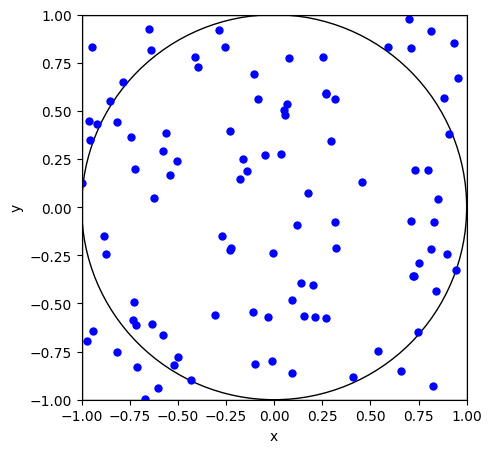

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.add_patch(plt.Rectangle((-1,-1), 2, 2, fill=False))
ax.add_artist(plt.Circle((0, 0), 1, fill=False))
x = np.random.uniform(-1, 1, size=100)
y = np.random.uniform(-1, 1, size=100)
ax.scatter(x, y, s=25, c='blue', marker='o')
plt.show()


By laws of large numbers, $\pi$ can be approximated by a stochastic algorithm

$$
E\left[\boldsymbol{1}\left\{ x^{2}+y^{2}\leq1\right\} \right] = \frac{\pi r^{2}}{\left(2r\right)^{2}}= \frac{\pi}{4}
$$

it implies  $\pi=4\times E[ 1 \{  x^{2}+y^{2}\leq1 \}]$. 

In [9]:
import numpy as np

n = 20000000
Z = 2 * np.random.rand(n, 2) - 1

inside = np.mean(np.sqrt(np.sum(Z**2, axis=1)) <= 1)
print(f"The estimated pi = {inside * 4:.6f}")


The estimated pi = 3.141816


* Sample size can be made as large as the computer's memory permits.
* Iterate it with average of averages and so on, for higher accuracy.

## Writing Script

* A script is a piece of code for a particular purpose. Thousands of lines are not written from the beginning to the end. 

* Recursively development
  * small manageable tasks
  * test code constantly 
  * encapsulate into DIY functions

* Integrate small pieces into the super structure. 
* Add comments to the script to facilitate readability

## Finite Sample Evaluation


* Real world sample is finite
* Asymptotic theory is a mathematical apparatus to approximate finite sample distributions
* Modern econometric theory is built on asymptotics
* Simulation is one way to evaluate the accuracy of approximation.

## Example

For the OLS estimator, 

* Classical views $X$ as fixed regressions and only cares about the randomness of the error term.
* Modern econometrics textbook emphasizes that a random $X$ is more appropriate
for econometrics applications. 
* In rigorous textbooks, the moment of $X$ is explicitly stated as $E[X_i X_i'] < \infty$.

* A Pareto distribution with shape coefficient between 1 and 2 has finite population mean, but infinite variance. 
* If $X$ follows a
[Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) with shape coefficient 1.5, it violates the assumptions for OLS stated in most of econometric textbooks.
* Question: Is asymptotic inferential theory for the OLS estimator valid? 

We write a script to investigate this problem. The following steps develop the code.

 1. given a sample size, get the OLS `b_hat` and its associated `t_value`.
 2. wrap `t_value` as a user-defined function so that we can reuse it for many times.
 3. given a sample size, report the size under two distributions.
 4. wrap step 3 again as a user-defined function, ready for different sample sizes.
 5. develop the super structure to connect the workhorse functions.
 6. add comments and documentation.


### $t$-statistic

$$
\sqrt{n} (\hat{\beta} - \beta_0) |X = (X'X/n)^{-1}  (X' e /\sqrt{n}),
$$

the $k$-th element of the vector coefficient conditional on $X$ is
$$
\widehat{\beta}_{k}|X=\eta_{k}'\widehat{\beta}|X
\sim N\left(\beta_{k},\sigma^{2}\left(X'X\right)_{kk}^{-1}\right).
$$

In [10]:
import numpy as np
from scipy.stats import norm, t

def simulation(n, dist='normal', df=5):
    if dist == 'normal':
        e = np.random.normal(size=n)
    elif dist == 't':
        e = np.random.standard_t(df, size=n)

    X = np.column_stack((np.ones(n), np.random.pareto(1.5, size=n)))
    Y = X.dot(b0) + e

    bhat = np.linalg.lstsq(X, Y, rcond=None)[0]
    bhat2 = bhat[1] # parameter we want to test

    e_hat = Y - X.dot(bhat)
    sigma_hat_square = np.sum(e_hat**2) / (n - 2)
    sig_B = np.linalg.inv(X.T.dot(X)) * sigma_hat_square
    t_value_2 = (bhat2 - b0[1]) / np.sqrt(sig_B[1, 1])

    return t_value_2



In [11]:
from scipy.stats import t, norm

def report(n):
    # collect the test size from the two distributions
    # this function contains some repetitive code, but is OK for such a simple one
    TEST_SIZE = np.zeros(3)

    # e ~ normal distribution, under which the t-dist is exact
    Res = np.array([simulation(n, 'normal') for i in range(Rep)])
    TEST_SIZE[0] = np.mean(np.abs(Res) > t.ppf(0.975, n-2))
    TEST_SIZE[1] = np.mean(np.abs(Res) > norm.ppf(0.975))

    # e ~ t-distribution, under which the exact distribution is complicated.
    # we rely on asymptotic normal distribution for inference instead
    Res = np.array([simulation(n, 't', df) for i in range(Rep)])
    TEST_SIZE[2] = np.mean(np.abs(Res) > norm.ppf(0.975))

    return TEST_SIZE


In [17]:
Rep = 1000
b0 = np.ones((2, 1))
df = 1  # t dist. with df = 1 is Cauchy

# run the calculation of the empirical sizes for different sample sizes
NN = [5, 10, 200]
RES = np.zeros((len(NN), 4))
RES[:, 0] = NN
for i, n in enumerate(NN):
    test_sizes = report(n)
    RES[i, 1] = test_sizes[0]  # exact
    RES[i, 2] = test_sizes[1]  # normal asymptotic
    RES[i, 3] = test_sizes[2]  # Cauchy asymptotic

print(pd.DataFrame(RES, columns=['n', 'exact', 'normal.asym', 'cauchy.asym']))



       n     exact  normal.asym  cauchy.asym
0    5.0  0.000000     0.000000     0.001600
1   10.0  0.000000     0.000300     0.004200
2  200.0  0.003925     0.004055     0.004695


### Simulation Results

* 1st column: the error is normal, use exact distribution theory to find the critical value (according to $t$-distribution.)

* 2nd column: still uses the normal error
  * change the critical value to asymptotic normal distribution
  
* 3rd column: error distribution is Cauchy
  * asymptotic approximation breaks down
  * test size does not converge to the nominal 5%  

### Observations

* $X$ is always Pareto 
* distribution of $X$ doesn't matter in our simulations

### Justification


The $t$-statistic

$$
T_{k}  =\frac{\widehat{\beta}_{k}-\beta_{k}}{\sqrt{s^{2}\left[\left(X'X\right)^{-1}\right]_{kk}}} =\frac{\widehat{\beta}_{k}-\beta_{k}}{\sqrt{\sigma^{2}\left[\left(X'X\right)^{-1}\right]_{kk}}}\cdot\frac{\sqrt{\sigma^{2}}}{\sqrt{s^{2}}}\\
  =\frac{\left(\widehat{\beta}_{k}-\beta_{k}\right)/\sqrt{\sigma^{2}\left[\left(X'X\right)^{-1}\right]_{kk}}}{\sqrt{\frac{e'}{\sigma}M_{X}\frac{e}{\sigma}/\left(n-K\right)}}.
$$

* Self-normalized $t$ statistic does not break down despite that $X'X/n$ does not converge
* Regardless the distribution of $X$, when the error term is normal 
  * numerator follows $N(0,1)$
  * demonimator follows $\chi^2$

### World View


* Fundamental question: how to quantify uncertainty.
  * data $(X_1,X_2,\ldots,X_n)$
  * sample mean $\bar{X}$
  * sample variance $s$
  * frequentist confidence interval about the population mean

* Asymptotics is imaginary.
* Let's be realistic: we have a finite sample $n$.

## Bootstrap

* Let $X_1, X_2, \ldots, X_n \sim F$ be an i.i.d. sample of $n$ observations following a distribution $F$. 
* The finite sample distribution of a statistic $T_n(\theta)\sim G_n(\cdot, F)$ usually depends on the sample size $n$, as well as the unknown true distribution $F$. 


### Key Idea

* Bootstrap replaces the unknown distribution $F$ in $G_n(\cdot, F)$ by the empirical distribution function

$$
\hat{F}_n(\cdot) = n^{-1} \sum_{i=1}^n 1\{\cdot \leq X_i\}
$$

* Bootstrap inference is drawn from the bootstrap distribution

$$
G_n(\cdot, \hat{F}_n)
$$


### Key Idea

* Bootstrap replaces the unknown distribution $F$ in $G_n(\cdot, F)$ by the empirical distribution function

$$
\hat{F}_n(\cdot) = n^{-1} \sum_{i=1}^n 1\{\cdot \leq X_i\}
$$

* Bootstrap inference is drawn from the bootstrap distribution

$$
G_n(\cdot, \hat{F}_n)
$$


### Compare to Asymptotic Theory

* Bootstrap is a finite-sample practice 
* It doesn't refer to an imaginary world where $n\to \infty$ at its face value


* Asymptotic theory approximates $G_n(\cdot, F)$ by its limit 

$$G(\cdot, F) := \lim_{n\to\infty} G_n(\cdot, F).$$ 

* In many cases $G(\cdot, F)$ is independent of $F$ and it becomes $G(\cdot)$. Such a $T_n(\theta)$ is called *asymptotically pivotal*, 

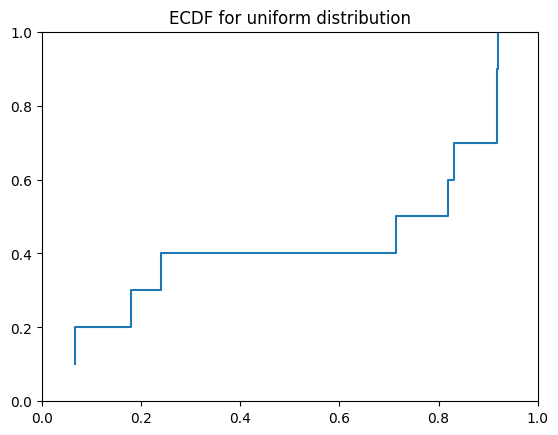

In [26]:
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

x = np.random.uniform(size=10)
ecdf = ECDF(x)

# get unique sorted values of x and corresponding values of y
ux, uy = np.unique(ecdf.x, return_index=False, return_inverse=False, return_counts=False), ecdf.y[np.unique(ecdf.y, return_index=True, return_inverse=False, return_counts=False)[1]]

# add last point (1,1) to the step function
ux = np.concatenate((ux, [1]))
uy = np.concatenate((uy, [1]))

# create step function with horizontal lines
plt.plot(ux[:-1], uy[:-1], drawstyle='steps-pre')
plt.plot([ux[-2], ux[-1]], [uy[-2], uy[-2]], color='C0', linestyle='--')
plt.plot([ux[-1], ux[-1]], [uy[-2], uy[-1]], color='C0', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ECDF for uniform distribution')
plt.show()

### Nonparametric Bootstrap

* Implementation of bootstrap is a simulation exercise. 
* In an i.i.d. environment, $n$ observations are drawn with equal weight and **with replacement** from the realized sample

### Variants of Bootstrap Schemes

* Block bootstrap: preserve dependence structure
  * dependent dataset such as time series
  * clustering data or networks

* parametric bootstrap
  * In regressions we fix the regressors

* wild bootstrap: [[Davidson, 2010]](https://www.tandfonline.com/doi/abs/10.1198/jbes.2009.07221?journalCode=ubes20)
  * Heteroskedascity

In [27]:
import pandas as pd
import numpy as np

n = 9  # real sample size
real_sample = np.random.normal(size=n)  # the real sample
d0 = pd.DataFrame({'no': np.arange(1, n+1), 'x': real_sample})
print(d0)

# bootstrap
boot_Rep = 3  # bootstrap 3 times
d_boot = []  # save the bootstrap sample
for b in range(boot_Rep):
    boot_index = np.random.choice(n, n, replace=True)
    d_boot.append(pd.DataFrame({'no': boot_index+1, 'x': real_sample[boot_index]}))

d_boot = pd.concat(d_boot, ignore_index=True)  # combine the bootstrap samples
print(d_boot)


   no         x
0   1 -0.443977
1   2  0.263450
2   3  0.125896
3   4  0.871790
4   5  0.681630
5   6 -0.716644
6   7 -0.901991
7   8 -2.131238
8   9  1.376135
    no         x
0    2  0.263450
1    8 -2.131238
2    3  0.125896
3    9  1.376135
4    7 -0.901991
5    3  0.125896
6    1 -0.443977
7    4  0.871790
8    2  0.263450
9    7 -0.901991
10   3  0.125896
11   9  1.376135
12   2  0.263450
13   7 -0.901991
14   1 -0.443977
15   9  1.376135
16   4  0.871790
17   2  0.263450
18   7 -0.901991
19   1 -0.443977
20   2  0.263450
21   2  0.263450
22   3  0.125896
23   9  1.376135
24   9  1.376135
25   1 -0.443977
26   1 -0.443977


### Bootstrap Estimation


* R package [boot](http://cran.r-project.org/web/packages/boot/index.html) provides a general function `boot()`.
* `ply`-family functions for repeated simulations. 

* Bootstrap is convenient. 
  * Analytic formula of the variance of an econometric estimator can be complex to derive or code up.

## Example

* One of the most popular estimators for a sample selection model is @heckman1977sample's two-step method

* Outcome equation

$$
y_i = x_i \beta + u_i
$$

and the selection equation be

$$
D_i = z_i \gamma + v_i
$$

* To obtain a point estimator, we simply run a Probit in the selection model, predict the probability of participation, and then run an OLS of $y_i$ on $x_i$ and $\lambda (\hat{D}_i)$ in the outcome model, where $\lambda(\cdot)$ is the inverse Mill's ratio. 

* From Heckman (1979)'s original paper, the asymptotic variance expression of the two-step estimator is very complicated.

* Instead of following the analytic formula, we can simply bootstrap the variance.

# Could not find a counterpart for package sampleSelection here
I tried to use the code from Bob Hicks but failed\
https://rlhick.people.wm.edu/econ407/book/docs/mle_heckman.html

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Load data
data = pd.read_csv('data_example/Mroz87.csv')

# Define selection equation
selection_eq = 'lfp ~ -1 + age + faminc + exper + educ'

# Define outcome equation
outcome_eq = 'wage ~ exper + educ'

# Fit Heckman selection model
heck = sm.selection.selection_models.Select2SLS.from_formula(
    outcome_eq, selection_eq, data)

heck_fit = heck.fit(method='ml')
print(heck_fit.summary())

AttributeError: module 'statsmodels.api' has no attribute 'selection'

* Below is the function for a single bootstrap. 

In [46]:
import numpy as np
import pandas as pd
import sampleSelection

# load the dataset
data = pd.read_csv('data_example/Mroz87.csv')

# equations
selection_eq = 'lfp ~ age + faminc + exper + educ'
outcome_eq = 'wage ~ exper + educ'

# bootstrap function
def boot_heck():
    n = data.shape[0]
    indices = np.random.choice(n, n, replace=True)
    Mroz87_b = data.iloc[indices, :]
    heck_b = sampleSelection.heckman(selection_eq, outcome_eq, data=Mroz87_b)
    return heck_b.params

# run bootstrap
np.random.seed(888)
boot_res = pd.DataFrame([boot_heck() for i in range(1000)])
print(boot_res.head())


ModuleNotFoundError: No module named 'sampleSelection'

* Implementation is just a repeated evaluation.

In [47]:
import numpy as np
import pandas as pd
import sampleSelection
import wooldridge

# load the dataset
data = wooldridge.data('Mroz87')

# equations
selection_eq = 'lfp ~ age + faminc + exper + educ'
outcome_eq = 'wage ~ exper + educ'

# bootstrap function
def boot_heck():
    n = data.shape[0]
    indices = np.random.choice(n, n, replace=True)
    Mroz87_b = data.iloc[indices, :]
    heck_b = sampleSelection.heckman(selection_eq, outcome_eq, data=Mroz87_b)
    return heck_b.params

# repeat bootstrap
np.random.seed(888)
boot_Rep = 199
Heck_B = pd.DataFrame([boot_heck() for i in range(boot_Rep)])

# collect the bootstrap outcomes
Heck_b_sd = Heck_B.std()[0:7]
print(Heck_b_sd)

ModuleNotFoundError: No module named 'sampleSelection'

### Bootstrap Test

* Bootstrap is particularly helpful in inference

### Example

* Test a hypothesis about the population mean. 

* Use $t$-statistic
* Distribution of the sample is either
  * normal
  * zero-centered chi-square 

* We will show that the bootstrap test size is
more precise than that of the asymptotic approximation.

In [1]:
import numpy as np
from scipy.stats import t

def T_stat(Y, mu):
    n = len(Y)
    return np.sqrt(n) * (np.mean(Y) - mu) / np.std(Y, ddof=1)

def boot_test(Y, alpha, boot_Rep):
    n = len(Y)
    boot_T = np.zeros(boot_Rep)

    for r in range(boot_Rep):
        indices = np.random.choice(n, n, replace=True)
        resampled_Y = Y[indices]
        boot_T[r] = abs(T_stat(resampled_Y, np.mean(Y)))

    boot_critical_value = np.quantile(boot_T, 1 - alpha)
    return boot_critical_value



### Bootstrap World

* The null hypothesis must be imposed no matter the hypothesized parameter is true value or not.

* Bootstrap $t$-statistic is

$$
T^{*}_{n} = \frac{\sqrt{n} (\bar{X^{*}} - \bar{X}) } { s^{*}  }.
$$



### Design the Statistic


* In the bootstrap world the **true** distribution is $F_n$
* The bootstrap $t$-statistic is centered around $\bar{X}$, the sample mean of $F_n$
* If we wrongly center it around the population mean $\theta$, then the test will have no power when the null hypothesis is false.

The following chuck of code report the rejection probability from three decision rules.

In [8]:
import numpy as np
from scipy.stats import t, norm, chi2

def T_stat(Y, mu):
    n = len(Y)
    return np.sqrt(n) * (np.mean(Y) - mu) / np.std(Y)

def boot_test(Y, boot_Rep):
    n = len(Y)
    boot_T = np.zeros(boot_Rep)

    for r in range(boot_Rep):
        indices = np.random.choice(n, n, replace=True)
        resampled_Y = Y[indices]
        boot_T[r] = abs(T_stat(resampled_Y, np.mean(Y)))

    boot_critical_value = np.quantile(boot_T, 1 - alpha)
    return boot_critical_value

def compare():
    if distribution == "normal":
        X = np.random.normal(size=n)
    elif distribution == "chisq":
        X = chi2.rvs(n-1, size=n) - n + 1

    t_value_X = T_stat(X, mu)

    exact = abs(t_value_X) > t.ppf(1 - alpha/2, n-1)
    asym = abs(t_value_X) > norm.ppf(1 - alpha/2)
    boot_rule = abs(t_value_X) > boot_test(X, boot_Rep)

    return np.array([exact, asym, boot_rule])

n = 10
distribution = "normal"
boot_Rep = 199
MC_rep = 2000
alpha = 0.05
mu = 0

res = np.zeros((MC_rep, 3))

for i in range(MC_rep):
    res[i,:] = compare()

print(np.mean(res, axis=0))


[0.069  0.1045 0.047 ]


### Results

* The program reports the empirical size.
* Nominal size of the test is 5%. 
* Bootstrap test is more accurate


* When the underlying distribution is a $\chi^2$, the exact distribution is difficult 
to derive analytically. 
* However, we can still compare the asymptotic size with the bootstrap size.

In [14]:
import pandas as pd
import numpy as np
distribution = "chisq"
boot_Rep = 199
MC_rep = 2000
alpha = 0.05
mu = 0

res = np.zeros((MC_rep, 3))

for i in range(MC_rep):
    res[i,:] = compare()

print(np.mean(res, axis=0))

[0.064  0.0985 0.0485]


* Here the "exact test" is no longer exact. 
* The asymptotic test works fairly reasonable
* Bootstrap is closer to the nominal size 5%.

## Reading

* [ISLR](https://www.statlearning.com/): Ch 5.2
* [CASI](https://hastie.su.domains/CASI/): Ch 10.2-4